# Classical Machine Learning for Breast Cancer Prediction

This notebook demonstrates a streamlined classical machine learning (ML). We will build a selection of models, using multiple algorithms and techniques, and compare their performance. As in the [previous episode](1_data_explore.ipynb), the dataset we will be using is the [Indian Liver Patient Dataset](https://www.kaggle.com/datasets/jeevannagaraj/indian-liver-patient-dataset).

## Key Objectives
- Apply **multiple classical ML algorithms**
- Perform **feature selection** and **preprocessing**
- Use **cross-validation** and **hyperparameter tuning**
- Compare model **performance** and **interpretability**

## 1. Importing Packages and Loading Data

First off, let's import the main functions we'll be using. As a Python user, you have a powerful toolkit for machine learning at your disposal. 

- [Numpy](https://numpy.org/) is a numerical computing library with an efficient backend implemented in C.
- [Pandas](https://pandas.pydata.org/) provides DataFrame functionality, which is a convenient way of storing and manipulating labelled data. 
- [Matplotlib](https://matplotlib.org/) is for building visualisations, and [Seaborn](https://seaborn.pydata.org/) extends its functionality with high-level statistical plots. 
- Most importantly for our purposes, [Scikit-learn](https://scikit-learn.org/stable/) which implements a huge number of machine learning algorithms.

In [72]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn essentials
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, confusion_matrix

# Classical ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')

Next we load the data. We can read it directly into a Pandas dataframe as before, and print out a list of the column headings.

In [73]:
data = pd.read_csv("../data/liver_augmented.csv")
print(data.columns)

Index(['age', 'tot_bilirubin', 'direct_bilirubin', 'tot_proteins', 'albumin',
       'ag_ratio', 'sgpt', 'sgot', 'alkphos', 'is_patient', 'gender_Female'],
      dtype='object')


In [74]:
data.head()

,age,tot_bilirubin,direct_bilirubin,tot_proteins,albumin,ag_ratio,sgpt,sgot,alkphos,is_patient,gender_Female
0,1.236928,-0.420124,-0.495190,-0.429625,-0.352659,-0.315148,0.280819,0.194225,-0.150315,0,1
1,1.052432,1.203777,1.406906,1.654054,-0.088755,-0.033926,0.925059,0.068445,-0.651328,0,0
2,1.052432,0.630636,0.913770,0.803490,-0.110747,-0.143671,0.464887,0.194225,-0.181628,0,0
3,0.806437,-0.372362,-0.389518,-0.449974,-0.363655,-0.308289,0.280819,0.320004,0.162818,0,0
4,1.667418,0.089335,0.174066,-0.397068,-0.292181,-0.174537,0.740991,-0.937791,-1.715981,0,0


## Data Exploration

A reminder of the shape and distribution of the data

In [75]:
# Load and explore the data:
print(f"Data shape: {data.shape}")

# Missing values (if any):
print(f"\nMissing values: {data.isnull().sum().sum()}")

# Target distribution:
class_dist = data['is_patient'].value_counts()

print("Target distribution:")
print("-" * 50)
print(f"Not a patient: {class_dist[0]} ({class_dist[0] / len(data) * 100:.1f}%)")
print(f"Liver Patient: {class_dist[1]} ({class_dist[1] / len(data) * 100:.1f}%)")
print(f"\nClass ratio (Not a Patient : A Liver Patient): {class_dist[0]/class_dist[1]:.2f}:1")

Data shape: (566, 11)

Missing values: 0
Target distribution:
--------------------------------------------------
Not a patient: 404 (71.4%)
Liver Patient: 162 (28.6%)

Class ratio (Not a Patient : A Liver Patient): 2.49:1


## 2. Feature Analysis & Selection

This section first separates the dataset into predictors (X) and the outcome variable (y) so that the features can be analysed independently of the label. The is_patient column is isolated as `y` while all remaining clinical measurements become `X`. 

Next, a simple univariate correlation is computed between each feature and the binary target; taking the absolute value of each correlation provides a ranking by strength regardless of direction (positive or negative), which makes it easy to identify the features most strongly associated with malignancy. The top ten features by absolute correlation are printed so you can inspect the strongest individual signals, and the top fifteen are plotted as a bar chart to give a compact visual comparison of relative importance. 

Note that this step is exploratory: correlation highlights linear associations and does not prove causation or capture non-linear relationships, so it is used here only to inform later feature-selection and modelling decisions (the actual model pipeline will use a formal selection method).  

In [76]:
# Create the feature matrix X by dropping the 'is_patient' column from the dataset
X = data.drop('is_patient', axis=1)

# Create the target vector y by selecting the 'is_patient' column
y = data['is_patient']

# Calculate the correlation between each feature and the target,
# take the absolute values, and sort from highest to lowest
correlations = X.corrwith(y).abs().sort_values(ascending=False)

print("Top 10 Features by Correlation with Target:")
print("-" * 45)

# Loop through the correlations (with index i starting from 1)
for i, (feature, corr) in enumerate(correlations.items(), 1):

    print(f"{i:2d}. {feature:<25} | {corr:.3f}")

Top 10 Features by Correlation with Target:
---------------------------------------------
 1. direct_bilirubin          | 0.251
 2. tot_bilirubin             | 0.224
 3. tot_proteins              | 0.186
 4. alkphos                   | 0.171
 5. sgot                      | 0.165
 6. albumin                   | 0.162
 7. ag_ratio                  | 0.151
 8. age                       | 0.134
 9. gender_Female             | 0.077
10. sgpt                      | 0.036


## 3. Data Preprocessing & Splitting

We prepare the data for modelling by selecting the most informative predictors, splitting into train/test sets, and standardising features to ensure fair treatment by scale-sensitive algorithms. Concretely, the dataset is split 80/20 with stratification on the diagnosis to preserve class balance. The split is random, but the randomiser uses a fixed seed for reproducibility. 

A StandardScaler is fit on the training set and used to transform both training and test features. Scaling helps algorithms like SVM, KNN and logistic regression converge and behave sensibly - without it, variables that have a larger range tend to dominate predictions. Tree-based methods are generally more robust to differences in scale. Fitting the scaler only on the training set avoids information leakage. 

In [77]:
# Split the data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Feature selection is carried out on the scaled training data using a univariate ANOVA F-test (SelectKBest with f_classif). Compared with simple correlation, the ANOVA F-test explicitly measures how well each feature discriminates between the two diagnostic classes by comparing between-class and within-class variance, a more principled way to rank predictive power. We keep the top features to reduce dimensionality while retaining the strongest signals (a choice informed by the prior correlation analysis). The selector is fit only on the training set and then applied to the test , again to avoid leakage. The names of the selected features are printed for reference before proceeding to model training.

In [78]:
# If we were to use feature selection, we could so with this:
selector = SelectKBest(f_classif, k=5)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names:
selected_features = X.columns[selector.get_support()].tolist()
print(f"Selected features ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

Selected features (5):
 1. tot_bilirubin
 2. direct_bilirubin
 3. tot_proteins
 4. albumin
 5. ag_ratio


As we only have a few features it's not worth doing feature selection here, unless we thought one was having an adverse effect on the results. With feature selection it's always important to know that weak correlating or non discriminating features may still contribute to the prediction when combined with other features in a high dimensional space.

In [79]:
# Overwrite the feature selection as we're not using it here
X_train_selected = X_train_scaled
X_test_selected = X_test_scaled

## 3. Model Training & Evaluation

In this section we built and evaluate our models. We define a small suite of classical classifiers (logistic regression, random forest, SVM, k‑nearest neighbours and gradient boosting) and train each one on the preprocessed training data. Using the same selected features and scaling avoids data leakage and ensures each algorithm is compared on an identical input representation, so differences in performance reflect the model behaviour rather than data preprocessing choices.

For each model we fit to the training split, and generate predictions and predicted probabilities on the held‑out test set. Because not all models produce probabilities, we check that probabilities are available - even though the models we use here do all produce them. 

We also compute a set of complementary evaluation metrics (accuracy, precision, recall and F1) to capture different aspects of predictive performance, and use ROC‑AUC to assess ranking ability independent of a threshold. To estimate generalisation more robustly we also compute 5‑fold cross‑validation accuracy on the training data. All results are collected into a dictionary and converted to a Pandas DataFrame so that models can be compared side‑by‑side in a clear tabular format.

![Cross validation cross validation](../assets/grid_search_cross_validation.png)

In [80]:
# Define models in a dictionary:

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

In [81]:
# Iterate through, train and evaluate each model:
results = {}

for name, model in models.items():
    # Train model
    model.fit(X_train_selected, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_selected)
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Cross-validation score
    cv_score = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='accuracy').mean()
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'CV Score': cv_score
    }

# Display results
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
print("=" * 60)
print(results_df.round(3))

Model Performance Comparison:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC  CV Score
Logistic Regression     0.746      0.643   0.273     0.383    0.802     0.710
Random Forest           0.719      0.533   0.242     0.333    0.726     0.712
SVM                     0.711      0.000   0.000     0.000    0.717     0.715
K-Nearest Neighbors     0.579      0.273   0.273     0.273    0.610     0.684
Gradient Boosting       0.702      0.480   0.364     0.414    0.719     0.697


![Scores diagram](../assets/Confusion-matrix-Precision-Recall-Accuracy-and-F1-score.png)

## 3b. Model Comparison & Visualisation

This section builds a compact 2×2 figure that summarises model performance from several complementary perspectives, so we can quickly compare the strengths and weaknesses of each model. The top-left and top-right panels show simple bar charts of Accuracy and F1‑Score across the candidate classifiers — these give a straightforward view of overall correctness and the balance between precision and recall, respectively. The lower-left panel displays ROC‑AUC, which measures ranking ability independent of any chosen decision threshold and is therefore useful when you care about relative confidence rather than a hard class label.  

The lower-right panel is a heatmap of key metrics (Accuracy, Precision, Recall, F1‑Score) that places multiple performance dimensions side‑by‑side; this makes it easy to spot models that trade a bit of accuracy for substantially better precision or recall, for example. We format the graphs to make them more readable, so that the relatively small differences between high‑performing models are easier to interpret.

Finally, the visualisation also highlights the best model by a chosen criterion (here accuracy) and prints its name and score so you have a clear, reproducible pick for subsequent hyperparameter tuning and final evaluation.

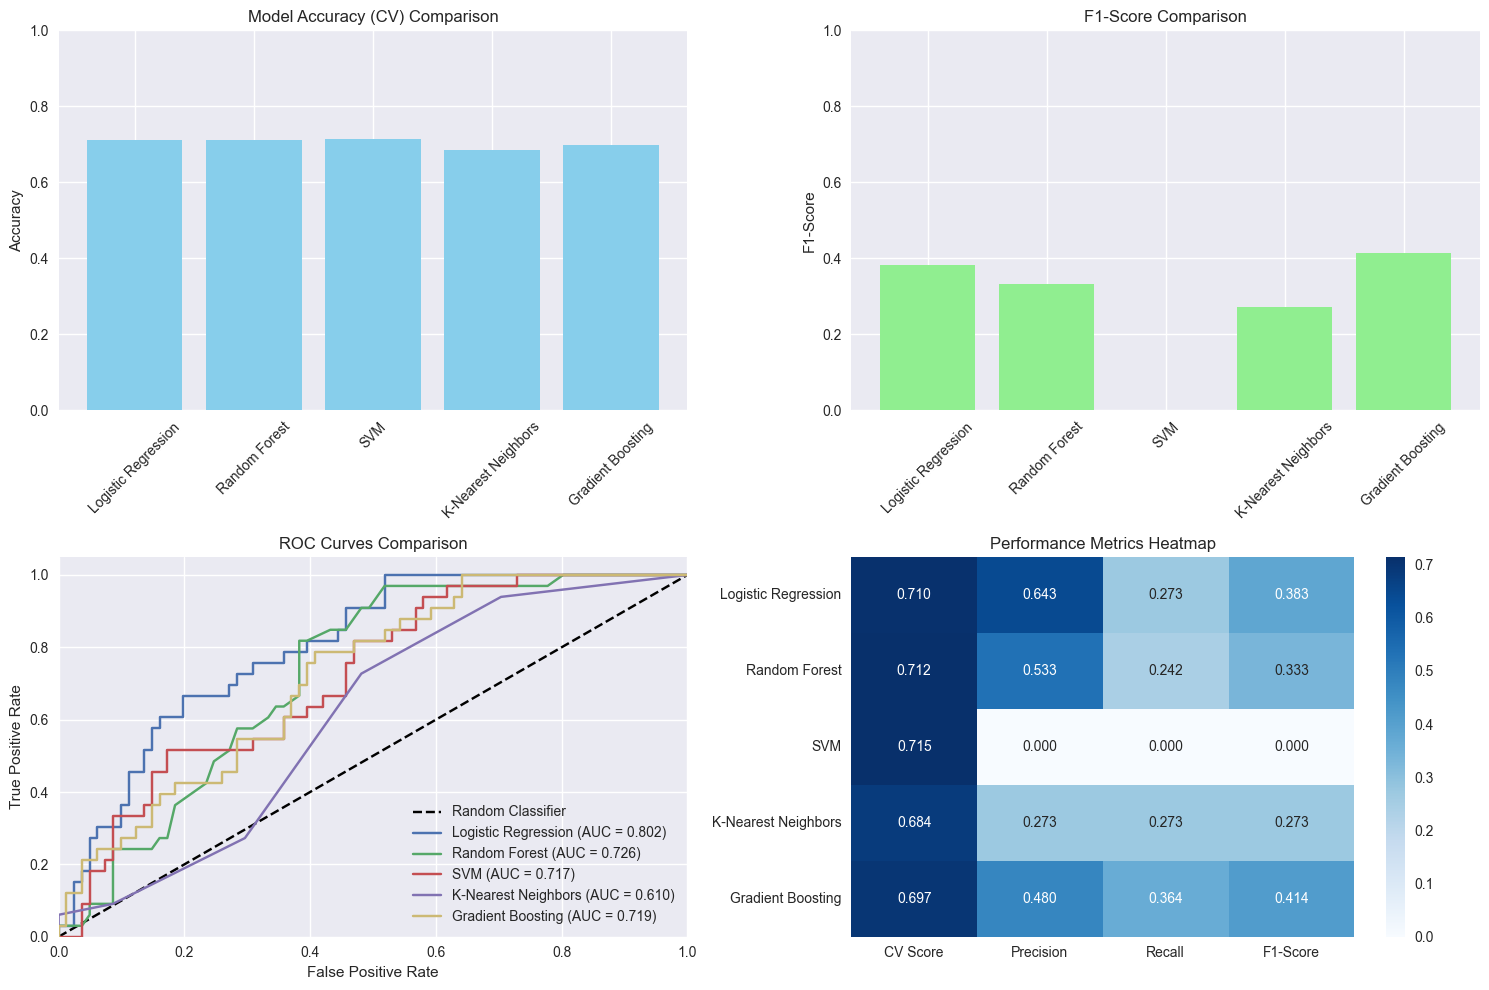

In [82]:
# Visualise model performance:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy comparison:
axes[0, 0].bar(results_df.index, results_df['CV Score'], color='skyblue')
axes[0, 0].set_title('Model Accuracy (CV) Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylim(0, 1)

# F1-Score comparison:
axes[0, 1].bar(results_df.index, results_df['F1-Score'], color='lightgreen')
axes[0, 1].set_title('F1-Score Comparison')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim(0, 1)

# Generate line indicating random:
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Loop through models :
for model_name, model in models.items():
    
    # Get probability predictions:
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_selected)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_selected)
    else:
        continue
    
    # Calculate ROC curve:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    
    # Plot:
    axes[1, 0].plot(fpr, tpr, label=f'{model_name} (AUC = {results[model_name]['ROC-AUC']:.3f})')

axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves Comparison')
axes[1, 0].legend(loc='lower right')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])

# Overall metrics heatmap:
metrics_heatmap = results_df[['CV Score', 'Precision', 'Recall', 'F1-Score']]
sns.heatmap(metrics_heatmap, annot=True, cmap='Blues', fmt='.3f', ax=axes[1, 1]) # vmax = 1, vmin = 0,
axes[1, 1].set_title('Performance Metrics Heatmap')

plt.tight_layout()
plt.show()

In [95]:
# Why do some have zero precision and recall

models['SVM'].predict(X_test_selected)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

## 4. Understanding the ROC curve

In [96]:
# Predictions from the Random Forest model 

y_predict = models['Random Forest'].predict(X_test_selected)

print(y_predict)

[0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


In [97]:
# Probabilities for class 1 with Random Forest

y_proba = models['Random Forest'].predict_proba(X_test_selected)[:, 1]

print(y_proba)

print(f"Lowest prediction probability: {min(y_proba)}")

print(f"Highest prediction probability: {max(y_proba)}")

[0.33 0.01 0.59 0.53 0.36 0.51 0.33 0.39 0.4  0.27 0.53 0.4  0.04 0.46
 0.54 0.4  0.61 0.01 0.48 0.27 0.3  0.34 0.52 0.36 0.49 0.1  0.05 0.43
 0.44 0.39 0.16 0.56 0.28 0.05 0.07 0.44 0.29 0.12 0.37 0.33 0.   0.47
 0.08 0.27 0.43 0.37 0.38 0.11 0.08 0.72 0.39 0.29 0.03 0.26 0.12 0.51
 0.76 0.08 0.41 0.37 0.52 0.03 0.42 0.2  0.11 0.42 0.47 0.32 0.11 0.57
 0.05 0.11 0.31 0.07 0.13 0.57 0.18 0.38 0.34 0.31 0.15 0.29 0.   0.29
 0.44 0.02 0.03 0.49 0.14 0.26 0.19 0.34 0.11 0.01 0.41 0.51 0.35 0.33
 0.44 0.17 0.31 0.41 0.33 0.43 0.49 0.23 0.42 0.19 0.11 0.31 0.48 0.3
 0.27 0.04]
Lowest prediction probability: 0.0
Highest prediction probability: 0.76


In [98]:
binary_threshold = y_proba > 0.5

all(models['Random Forest'].predict(X_test_selected) ==  binary_threshold)

True

In [99]:
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

for thresh in thresholds:

    # Get the classification given the threshold
    y_pred_thresh = (y_proba >= thresh).astype(int)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()

    # Calculate TPR and FPR 
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    print(f"\nThreshold = {thresh}:")
    print(f"  True Positive Rate: {tpr:.3f}")
    print(f"  False Positive Rate: {fpr:.3f}")


Threshold = 0.1:
  True Positive Rate: 0.970
  False Positive Rate: 0.778

Threshold = 0.3:
  True Positive Rate: 0.848
  False Positive Rate: 0.457

Threshold = 0.5:
  True Positive Rate: 0.242
  False Positive Rate: 0.086

Threshold = 0.7:
  True Positive Rate: 0.030
  False Positive Rate: 0.012

Threshold = 0.9:
  True Positive Rate: 0.000
  False Positive Rate: 0.000


https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

## 5. Hyperparameter Tuning - Refining your best model

In this step we perform targeted hyperparameter tuning to see if we can improve the accuracy of the model that performed best out-of-the-box, using a method called GridSearchCV. We define an appropriate parameter grid for each algorithm (for example: number and depth of trees for Random Forest, kernel/C/gamma combinations for SVM, or regularisation strength and penalty for Logistic Regression) and run GridSearchCV with 5‑fold cross‑validation to find the combination that maximises accuracy on the training set. GridSearchCV is fitted only on the training data (using the previously selected and scaled features), again to avoid data leakage. Once the best parameters are found, the corresponding estimator is applied to the held‑out test set. We print the optimal hyperparameters and the best cross‑validation score, then report final test performance — overall accuracy and a detailed classification report (precision, recall and F1 for each class) — so you can assess how well the tuned model generalises to unseen samples.

In [88]:
# Find the best model:
best_model_name = results_df['CV Score'].idxmax()
print(f"\nBest performing model: {best_model_name}")
print(f"'CV Accuracy: {results_df.loc[best_model_name, 'CV Score']:.3f}")


Best performing model: SVM
'CV Accuracy: 0.715


In [89]:
best_model_name = 'Random Forest'
print(f"'CV Accuracy: {results_df.loc[best_model_name, 'CV Score']:.3f}")

'CV Accuracy: 0.712


In [90]:
# Hyperparameter tuning for the best model:
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    best_model = RandomForestClassifier(random_state=42)
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1, 1],
        'kernel': ['rbf', 'linear']
    }
    best_model = SVC(random_state=42, probability=True)
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    best_model = LogisticRegression(random_state=42)
else:
    print('No model selected')

In [91]:
# Grid search:
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

print(f"Best parameters for {best_model_name}:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

Best parameters for Random Forest:
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.739


In [92]:
# pd.DataFrame(grid_search.cv_results_)

In [93]:
# Final evaluation:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test_selected)
final_accuracy = accuracy_score(y_test, final_predictions)

print(f"\nFinal optimised model accuracy: {final_accuracy:.3f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, final_predictions, target_names=['Benign', 'Malignant']))


Final optimised model accuracy: 0.693

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.73      0.89      0.80        81
   Malignant       0.44      0.21      0.29        33

    accuracy                           0.69       114
   macro avg       0.59      0.55      0.55       114
weighted avg       0.65      0.69      0.65       114



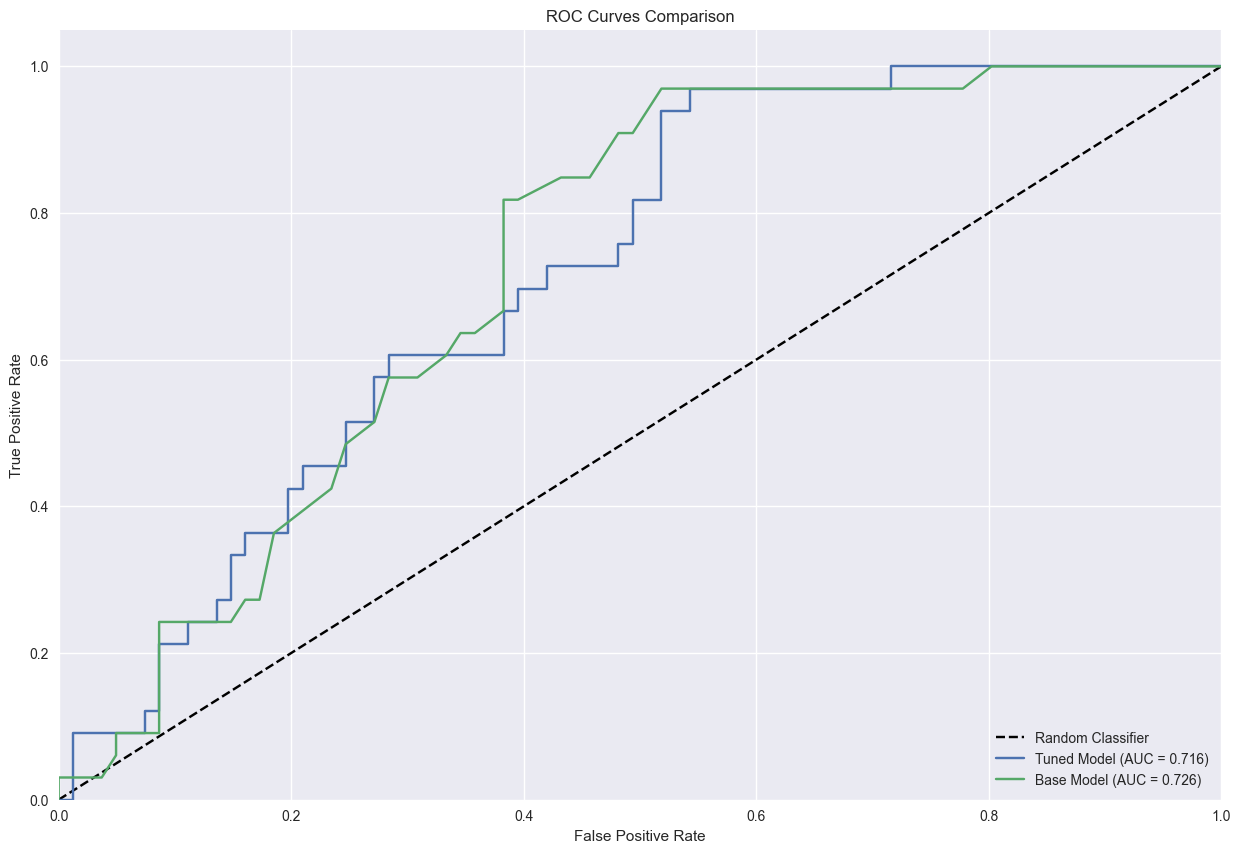

In [94]:
# Visualise model performance:
fig, axes = plt.subplots(figsize=(15, 10))

# Generate line indicating random:
axes.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

y_proba = final_model.predict_proba(X_test_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
axes.plot(fpr, tpr, label=f'{'Tuned Model'} (AUC = {roc_auc_score(y_test, y_proba):.3f})')

base_model = RandomForestClassifier(random_state=42).fit(X_train_selected, y_train)
y_proba = base_model.predict_proba(X_test_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
axes.plot(fpr, tpr, label=f'{'Base Model'} (AUC = {roc_auc_score(y_test, y_proba):.3f})')

axes.set_xlabel('False Positive Rate')
axes.set_ylabel('True Positive Rate')
axes.set_title('ROC Curves Comparison')
axes.legend(loc='lower right')
axes.set_xlim([0.0, 1.0])
axes.set_ylim([0.0, 1.05])

fig.show()

# 5. Models explained

This table summarises the models we built here.


| **Model** | **How it Works** | **Pros** | **Cons** | **Why it performed as shown** |
|-----------|------------------|----------|----------|-------------------------------|
| **Logistic Regression** | Fits a linear equation to the features and applies a **sigmoid** to predict probability of malignancy vs benign. Learns coefficients that describe how each feature affects log-odds of outcome. | - Very fast and interpretable<br>- Produces probabilities<br>- Works well on linearly separable problems | - Only linear boundaries<br>- Sensitive to multicollinearity<br>- Limited with complex feature interactions | Breast cancer features (like radius, texture, concavity) are **reasonably linearly separable**, so logistic regression already achieves **high accuracy and ROC-AUC**. Its simplicity means little overfitting, hence stable performance. |
| **Random Forest** | An **ensemble of decision trees** trained on bootstrapped subsets of the data and features. Prediction = majority vote (classification). | - Handles non-linearities<br>- Robust to noise/outliers<br>- Works well without scaling<br>- Provides feature importance | - Can be slower on very large datasets<br>- Less interpretable<br>- May overfit if trees are deep | Performs similarly to logistic regression here because the dataset is relatively low-dimensional (30 features) and well-structured. Gains from capturing non-linearities are modest because many features are individually strong predictors. |
| **Support Vector Machine (SVM)** | Finds a **hyperplane** that maximises the margin between classes. With kernels, can model non-linear decision boundaries. | - Effective in high-dimensional spaces<br>- Works well with clear margin separation<br>- Flexible with kernels | - Sensitive to parameter choice<br>- Can be slower on larger datasets<br>- Harder to interpret | Slightly lower scores than logistic regression and RF — probably because the data already separates well linearly, so the SVM’s extra complexity does not add much benefit and may even slightly reduce generalisation. |
| **K-Nearest Neighbours (KNN)** | Classifies a new point by looking at the **majority class of its k nearest neighbours** in feature space. | - Simple, intuitive<br>- No training phase<br>- Captures local structure | - Slow at prediction on larger datasets<br>- Sensitive to scaling and irrelevant features<br>- Struggles in high dimensions | Works well here because malignant and benign tumours cluster separately in feature space. However, noise and overlapping regions reduce its stability compared to LR and RF. |
| **Gradient Boosting** | Builds an **ensemble of weak learners (shallow trees)** sequentially, where each tree corrects errors of the previous. | - High accuracy<br>- Captures complex patterns<br>- Robust with tuning | - Computationally intensive<br>- Sensitive to hyperparameters<br>- Can overfit small datasets | Slightly lower in your chart because the dataset is not very complex — boosting adds unnecessary complexity and may overfit noise. With tuning, performance could rise, but here simplicity wins. |